<a href="https://colab.research.google.com/github/xRAFPx/AAII/blob/master/RNN_Multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Secção igual à do documento Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import requests
import json
import csv
import string
import io
import pandas as pd
from tempfile import NamedTemporaryFile
import shutil
from datetime import date
import datetime
import os.path
from os import path
import re
import xlrd
import math
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from getpass import getpass
from functools import reduce
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn import svm
from matplotlib import pyplot
from pandas.plotting import autocorrelation_plot
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

Using TensorFlow backend.


##Variáveis

In [ ]:
folder = '/content/drive/My Drive/Colab Notebooks/AII Project'
gitFolder = '/content/AAII/Data'
model_folder = folder + '/Model Output'
bestFileRNN_Multi = model_folder + '/bestResultsRNN_Multi.csv'

#Temperatura
norte_weather_filepath = folder + '/weather_norte.csv'
centro_weather_filepath = folder + '/weather_centro.csv'
lvt_weather_filepath = folder + '/weather_lvt.csv'
algarve_weather_filepath = folder + '/weather_algarve.csv'
alentejo_weather_filepath = folder + '/weather_alentejo.csv'

#Óbitos COVID-19
acores_death_filepath = folder + '/acores_death.csv'
madeira_death_filepath = folder + '/madeira_death.csv'
alentejo_death_filepath = folder + '/alentejo_death.csv'
algarve_death_filepath = folder + '/algarve_death.csv'
lvt_death_filepath = folder + '/lvt_death.csv'
centro_death_filepath = folder + '/centro_death.csv'
norte_death_filepath = folder + '/norte_death.csv'

#Casos Confirmados COVID-19
acores_filepath = folder + '/acores.csv'
madeira_filepath = folder + '/madeira.csv'
alentejo_filepath = folder + '/alentejo.csv'
algarve_filepath = folder + '/algarve.csv'
lvt_filepath = folder + '/lvt.csv'
centro_filepath = folder + '/centro.csv'
norte_filepath = folder + '/norte.csv'

In [ ]:
if path.exists(folder):
  print("No directory error")
else:
  #Create a new directory (a folder) in your Drive
  os.mkdir(folder)
  print("Directory created")

No directory error


In [ ]:
def read_dataset(url):
  df = pd.read_csv(url, parse_dates=[0], index_col=[0], infer_datetime_format=True)
  return df.fillna(value=0)

In [ ]:
df_norte_aux = read_dataset(norte_filepath)
# pd.set_option('display.max_rows', df_norte.shape[0]+1)
# print(df_norte)
df_centro_aux = read_dataset(centro_filepath)
df_lvt_aux = read_dataset(lvt_filepath)
df_alentejo_aux = read_dataset(alentejo_filepath)
df_algarve_aux = read_dataset(algarve_filepath)

In [ ]:
df_norte_aux.shape

(116, 1)

In [ ]:
df_alentejo_death = read_dataset(alentejo_death_filepath)
df_algarve_death = read_dataset(algarve_death_filepath)
df_lvt_death = read_dataset(lvt_death_filepath)
df_centro_death = read_dataset(centro_death_filepath)
df_norte_death = read_dataset(norte_death_filepath)

In [ ]:
df_norte_weather = read_dataset(norte_weather_filepath)
df_centro_weather = read_dataset(centro_weather_filepath)
df_lvt_weather = read_dataset(lvt_weather_filepath)
df_algarve_weather = read_dataset(algarve_weather_filepath)
df_alentejo_weather = read_dataset(alentejo_weather_filepath)

In [ ]:
df_norte_aux[df_norte_aux<0]=0
df_centro_aux[df_centro_aux<0]=0
df_lvt_aux[df_lvt_aux<0]=0
df_alentejo_aux[df_alentejo_aux<0]=0
df_algarve_aux[df_algarve_aux<0]=0

df_norte_death[df_norte_death<0]=0
df_centro_death[df_centro_death<0]=0
df_lvt_death[df_lvt_death<0]=0
df_alentejo_death[df_alentejo_death<0]=0
df_algarve_death[df_algarve_death<0]=0

#Preparação das variáveis

Na função create_predictor foi feita a junção dos preditores a utilizar: novos casos de óbitos por COVID, temperatura máxima e mínima.
Como o dataset da temperatura tem dados de antes do COVID, tive que fazer um mapeamento para obter apenas os dados a partir do dia 26 de fevereiro.

In [ ]:
def create_predictor(df, df_aux):
    df_predictor=df.copy()
    meanMinData = dict(zip(df_aux.index, df_aux['mean_x'].round()))
    meanMaxData = dict(zip(df_aux.index, df_aux['mean_y'].round()))
    df_predictor["temp_max"] = df.index.map(meanMaxData)
    df_predictor["temp_min"] = df.index.map(meanMinData)
    df_predictor = df_predictor.fillna(method='ffill')
    return df_predictor

Todos os dados foram normalizados de forma a obter dados mais facilmente tratavéis pelo modelo.

In [ ]:
def data_normalization(df):
  scaler = MinMaxScaler()
  df = scaler.fit_transform(df)
  return scaler, df

Tal como no exemplo univariado, neste exemplo foi feita a montagem do modelo supervisionado. Para cada 4 dias de dados de óbitos e temperatura tem como preditivo os dados dos novos casos confirmados do dia seguinte.

Como se trata de um problema de regressão (e não de classificação), estamos a tentar prever os resultados em uma saída contínua, o que significa que estamos a tentar mapear variáveis ​​de entrada (preditor) para alguma função contínua (preditivo).

Para este modelo a construção desta estrutura é fundamental para que os dados possam ser tratados pelo modelo.

In [ ]:
def build_multiSupervised(X, y, timesteps):
    dataX = X
    dataY = y
    X_s, y_s = list(), list()
    dataset_size = len(dataX)
    for curr_pos in range(dataset_size):
        input_index =  curr_pos + timesteps
        label_index = input_index + 1
        if label_index <= dataset_size:
            X_s.append(dataX[curr_pos:input_index, :])
            y_s.append(dataY[input_index:label_index])
    return np.array(X_s).astype('float32'), np.array(y_s).astype('float32')

In [ ]:
df_norte_predictor_aux = create_predictor(df_norte_death, df_norte_weather)
df_centro_predictor_aux = create_predictor(df_centro_death, df_centro_weather)
df_lvt_predictor_aux = create_predictor(df_lvt_death, df_lvt_weather)
df_alentejo_predictor_aux = create_predictor(df_alentejo_death, df_alentejo_weather)
df_algarve_predictor_aux = create_predictor(df_algarve_death, df_algarve_weather)

In [ ]:
scaler_norte, df_norte_aux = data_normalization(df_norte_aux)
scaler_centro, df_centro_aux = data_normalization(df_centro_aux)
scaler_lvt, df_lvt_aux = data_normalization(df_lvt_aux)
scaler_alentejo, df_alentejo_aux = data_normalization(df_alentejo_aux)
scaler_algarve, df_algarve_aux = data_normalization(df_algarve_aux)

In [ ]:
scaler_norte_predictor, df_norte_predictor_aux = data_normalization(df_norte_predictor_aux)
scaler_centro_predictor, df_centro_predictor_aux = data_normalization(df_centro_predictor_aux)
scaler_lvt_predictor, df_lvt_predictor_aux = data_normalization(df_lvt_predictor_aux)
scaler_alentejo_predictor, df_alentejo_predictor_aux = data_normalization(df_alentejo_predictor_aux)
scaler_algarve_predictor, df_algarve_predictor_aux = data_normalization(df_algarve_predictor_aux)

In [ ]:
timesteps = 4

In [ ]:
df_norte_predictor, df_norte = build_multiSupervised(df_norte_predictor_aux, df_norte_aux, timesteps)

In [ ]:
df_centro_predictor, df_centro = build_multiSupervised(df_centro_predictor_aux, df_centro_aux, timesteps)

In [ ]:
df_algarve_predictor, df_algarve = build_multiSupervised(df_algarve_predictor_aux, df_algarve_aux, timesteps)

In [ ]:
df_alentejo_predictor, df_alentejo = build_multiSupervised(df_alentejo_predictor_aux, df_alentejo_aux, timesteps)

In [ ]:
df_lvt_predictor, df_lvt = build_multiSupervised(df_lvt_predictor_aux, df_lvt_aux, timesteps)

In [ ]:
df_norte_predictor.shape

(112, 4, 3)

In [ ]:
df_norte.shape

(112, 1, 1)

80% para casos de treino, 10% para teste e 10% para validação

In [ ]:
valid_test_percent = 0.1
df_region_valid_test_size = int(np.round(valid_test_percent * df_norte.shape[0]))
df_region_train_size = df_norte.shape[0] - df_region_valid_test_size*2

In [ ]:
df_region_valid_test_size

11

In [ ]:
df_region_train_size

90

In [ ]:
#TRAIN
X_train_norte = df_norte_predictor[:df_region_train_size]
y_train_norte = df_norte[:df_region_train_size]

X_train_centro = df_centro_predictor[:df_region_train_size]
y_train_centro = df_centro[:df_region_train_size]

X_train_lvt = df_lvt_predictor[:df_region_train_size]
y_train_lvt = df_lvt[:df_region_train_size]

X_train_algarve = df_algarve_predictor[:df_region_train_size]
y_train_algarve = df_algarve[:df_region_train_size]

X_train_alentejo = df_alentejo_predictor[:df_region_train_size]
y_train_alentejo = df_alentejo[:df_region_train_size]


#TEST
X_test_norte = df_norte_predictor[df_region_train_size + df_region_valid_test_size :]
y_test_norte = df_norte[df_region_train_size + df_region_valid_test_size :]

X_test_centro = df_centro_predictor[df_region_train_size + df_region_valid_test_size :]
y_test_centro = df_centro[df_region_train_size + df_region_valid_test_size :]

X_test_lvt = df_lvt_predictor[df_region_train_size + df_region_valid_test_size :]
y_test_lvt = df_lvt[df_region_train_size + df_region_valid_test_size :]

X_test_algarve = df_algarve_predictor[df_region_train_size + df_region_valid_test_size :]
y_test_algarve = df_algarve[df_region_train_size + df_region_valid_test_size :]

X_test_alentejo = df_alentejo_predictor[df_region_train_size + df_region_valid_test_size :]
y_test_alentejo = df_alentejo[df_region_train_size + df_region_valid_test_size :]


#VALIDATION
X_val_norte = df_norte_predictor[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_norte = df_norte[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_centro = df_centro_predictor[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_centro = df_centro[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_lvt = df_lvt_predictor[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_lvt = df_lvt[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_algarve = df_algarve_predictor[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_algarve = df_algarve[df_region_train_size:df_region_train_size + df_region_valid_test_size]

X_val_alentejo = df_alentejo_predictor[df_region_train_size:df_region_train_size + df_region_valid_test_size]
y_val_alentejo = df_alentejo[df_region_train_size:df_region_train_size + df_region_valid_test_size]


#TRAIN+VALIDATION
X_train_val_norte = df_norte_predictor[:df_region_train_size + df_region_valid_test_size]
y_train_val_norte = df_norte[:df_region_train_size + df_region_valid_test_size]

X_train_val_centro = df_centro_predictor[:df_region_train_size + df_region_valid_test_size]
y_train_val_centro = df_centro[:df_region_train_size + df_region_valid_test_size]

X_train_val_lvt = df_lvt_predictor[:df_region_train_size + df_region_valid_test_size]
y_train_val_lvt = df_lvt[:df_region_train_size + df_region_valid_test_size]

X_train_val_algarve = df_algarve_predictor[:df_region_train_size + df_region_valid_test_size]
y_train_val_algarve = df_algarve[:df_region_train_size + df_region_valid_test_size]

X_train_val_alentejo = df_alentejo_predictor[:df_region_train_size + df_region_valid_test_size]
y_train_val_alentejo = df_alentejo[:df_region_train_size + df_region_valid_test_size]

In [ ]:
X_train_norte.shape

(90, 4, 3)

In [ ]:
y_train_norte.shape

(90, 1, 1)

In [ ]:
X_train_val_norte.shape

(101, 4, 3)

O reshape permite que em cada preditor e preditivo seja removida uma dimensão. 

In [ ]:
y_test_norte_re = y_test_norte.reshape(y_test_norte.shape[0],y_test_norte.shape[1])
y_train_val_norte_re = y_train_val_norte.reshape(y_train_val_norte.shape[0],y_train_val_norte.shape[1])

In [ ]:
y_test_centro_re = y_test_centro.reshape(y_test_centro.shape[0],y_test_centro.shape[1])
y_train_val_centro_re = y_train_val_centro.reshape(y_train_val_centro.shape[0],y_train_val_centro.shape[1])

In [ ]:
y_test_lvt_re = y_test_lvt.reshape(y_test_lvt.shape[0],y_test_lvt.shape[1])
y_train_val_lvt_re = y_train_val_lvt.reshape(y_train_val_lvt.shape[0],y_train_val_lvt.shape[1])

In [ ]:
y_test_alentejo_re = y_test_alentejo.reshape(y_test_alentejo.shape[0],y_test_alentejo.shape[1])
y_train_val_alentejo_re = y_train_val_alentejo.reshape(y_train_val_alentejo.shape[0],y_train_val_alentejo.shape[1])

In [ ]:
y_test_algarve_re = y_test_algarve.reshape(y_test_algarve.shape[0],y_test_algarve.shape[1])
y_train_val_algarve_re = y_train_val_algarve.reshape(y_train_val_algarve.shape[0],y_train_val_algarve.shape[1])

#Criação do modelo

In [ ]:
def rmse(y_true, y_pred):
    #RMSE = tf.sqrt(tf.losses.mean_squared_error(y_pred, y_true))
    #RMSE = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_pred, y_true))))
    return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))

In [ ]:
def model_grid_search(model_type, layers, dropout_rate, timesteps, features):
  model = tf.keras.models.Sequential() 
  if len(layers) > 0:
    for i in range(len(layers)):
      if model_type == 'RNN':
        if i == 0 and len(layers) > 1:
          model.add(tf.keras.layers.SimpleRNN(int(layers[i]), return_sequences=True, input_shape=(timesteps, features)))
          if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))  
        elif i == 0 and len(layers) == 1:
          model.add(tf.keras.layers.SimpleRNN(int(layers[i]), input_shape=(timesteps, features)))
        elif i == len(layers)-1:
          model.add(tf.keras.layers.SimpleRNN(int(layers[i])))
        else:
          model.add(tf.keras.layers.SimpleRNN(int(layers[i]), return_sequences=True))
          if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))  
      elif model_type == 'LSTM':
        if i == 0 and len(layers) > 1:
          model.add(tf.keras.layers.LSTM(int(layers[i]), return_sequences=True, input_shape=(timesteps, features)))
          if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))  
        elif i == 0 and len(layers) == 1:
          model.add(tf.keras.layers.LSTM(int(layers[i]), input_shape=(timesteps, features)))
        elif i == len(layers)-1:
          model.add(tf.keras.layers.LSTM(int(layers[i])))
        else:
          model.add(tf.keras.layers.LSTM(int(layers[i]), return_sequences=True))
          if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))  
      else:
        if i == 0 and len(layers) > 1:
          model.add(tf.keras.layers.GRU(int(layers[i]), return_sequences=True, input_shape=(timesteps, features)))
          if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))  
        elif i == 0 and len(layers) == 1:
          model.add(tf.keras.layers.GRU(int(layers[i]), input_shape=(timesteps, features)))
        elif i == len(layers)-1:
          model.add(tf.keras.layers.GRU(int(layers[i])))
        else:
          model.add(tf.keras.layers.GRU(int(layers[i]), return_sequences=True))
          if dropout_rate > 0: model.add(tf.keras.layers.Dropout(dropout_rate))  
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))  
  return model

In [ ]:
def train_dnn(model, alg, lr, Xtrain, Ytrain, epochs, batch_size):
    if alg == "adam":
        optimizer = tf.keras.optimizers.Adam(lr = lr)
    elif alg == "rmsprop":
        optimizer = tf.keras.optimizers.RMSprop(lr = lr)
    elif alg == "sgd_momentum":
        optimizer = tf.keras.optimizers.SGD(lr = lr, momentum = 0.9)
    else: optimizer = tf.keras.optimizers.SGD(lr = lr)
        
    model.compile(optimizer = optimizer, loss = rmse, metrics = ['mae', 'accuracy', rmse])
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'accuracy', factor = 0.2, patience = 50, min_lr = lr)
    model.fit(Xtrain, Ytrain, epochs = epochs, batch_size = batch_size, shuffle = False, verbose = 0, callbacks = [lr])

    return model

In [ ]:
def dnn_optimization(opt_params, Xtrain, Ytrain, Xval, Yval, iterations, timesteps, features, city, verbose = True):
    from random import choice
  
    best_acc = None
    best_loss = None

    if verbose:
      print("Topology\tDropout\tAlgorithm\tLearning Rate\tValidation Loss\tValidation Acc\tEpochs\tBatch Size\tModel Type\n")

    if "topology" in opt_params:
        topologies = opt_params["topology"]
    else: topologies = [[100]]
    if "algorithm" in opt_params:
        algs = opt_params["algorithm"]
    else: algs = ["adam"]
    if "lr" in opt_params:
        lrs = opt_params["lr"]
    else: lrs = [0.001]
    if "dropout" in opt_params:
        dropouts = opt_params["dropout"]
    else: dropouts= [0.0]
    if "epochs" in opt_params:
        epochs = opt_params["epochs"]
    else: epochs = [10000]
    if "batch_size" in opt_params:
        batch_sizes = opt_params["batch_size"]
    else: batch_sizes = [16]
    if "model" in opt_params:
        model = opt_params["model"]
    else: model = "LSTM"
    conf=list()
    for it in range(iterations):

        layers = choice(topologies)
        dropout_rate = choice(dropouts)
        model_type = choice(model)
        dnn = model_grid_search(model_type, layers, dropout_rate, timesteps, features)

        alg = choice(algs)
        lr = choice(lrs)
        epoch = choice(epochs)
        batch_size = choice(batch_sizes)
        
        dnn = train_dnn(dnn, alg, lr, Xtrain, Ytrain,  epoch, batch_size)
        results = dnn.evaluate(Xval, Yval, verbose = 0)
        
        if verbose: 
            print(str(layers), "\t", str(dropout_rate), "\t", alg, "\t", str(lr), "\t", str(results[0]), "\t", str(results[1]), "\t", str(epoch), "\t", str(batch_size), "\t", model_type)
        
        conf.append([layers, dropout_rate, alg, lr, results[0], results[1], epoch, batch_size, model_type])

        if best_loss is None or results[0] < best_loss:
            best_loss = results[0]
            best_acc = results[1]
            best_config = (layers, dropout_rate, alg, lr, epoch, batch_size, model_type)

    return best_config, best_acc, best_loss, conf

In [ ]:
def RNN_model_search(X_train, y_train, X_val, y_val, X_test, y_test, X_train_val, y_train_val, timesteps, features, city):

  export_file = model_folder + '/MultiRNN' + city + '.csv'
  opt_pars = {"topology":[[100, 50], [100, 100, 100], [50, 100, 50], [100, 150], [20, 20], [100, 20], [10,10,10]],
            "algorithm": [ "adam", "rmsprop", "sgd_momentum"],
            "lr": [0.01, 0.001, 0.0001],
            "dropout": [0.2, 0.5, 0.7],
            "epochs": [500, 1000, 10000],
            "batch_size": [8, 16, 32, 64],
            "model": ["RNN", "LSTM", "GRU"]
            }

  best_config, best_val_acc, best_val_loss, conf = dnn_optimization(opt_pars, X_train, y_train, X_val, y_val, 15, timesteps, features, city)  
  pd.DataFrame(conf).to_csv(export_file, header=["layers", "dropout", "algorithm", "learning rate", "val_loss", "val_acc", "epochs", "batch_size", "model"])    
  print("Best configuration:", best_config)
  print("Best validation accuracy:", best_val_acc) 
  print("Best validation loss:", best_val_loss)
  # take best configuration and retrain with whole training set
  # evaluate error on holdout test set
  best_model = model_grid_search(best_config[6], best_config[0], best_config[1], timesteps, features)

  best_model = train_dnn(best_model, best_config[2], best_config[3], X_train_val, y_train_val, best_config[4], best_config[5])
  test_results = best_model.evaluate(X_test, y_test, verbose = 0)
  print("Test set metrics:", test_results[0], test_results[1])
  test_file = list()
  test_file.append([city, test_results[0], test_results[1], best_val_acc, best_val_loss, best_config[0], best_config[1], best_config[2], best_config[3], best_config[4], best_config[5], best_config[6]])
  if path.exists(bestFileRNN_Multi):
      pd.DataFrame(test_file).to_csv(bestFileRNN_Multi, mode='a')    
  else:
    pd.DataFrame(test_file).to_csv(bestFileRNN_Multi, mode='w', header=["city", "test_loss", "test_acc", "val_acc", "val_loss", "layers", "dropout", "algorithm", "learning rate", "epochs", "batch_size", "model"])    
  return best_model

In [ ]:
model_norte = RNN_model_search(X_train_norte, y_train_norte, X_val_norte, y_val_norte, X_test_norte, y_test_norte, X_train_val_norte, y_train_val_norte, X_train_norte.shape[1], X_train_norte.shape[2], "Norte")

Topology	Dropout	Algorithm	Learning Rate	Validation Loss	Validation Acc	Epochs	Batch Size	Model Type

[50, 100, 50] 	 0.7 	 adam 	 0.01 	 0.024883748963475227 	 0.018670009449124336 	 1000 	 32 	 LSTM
[20, 20] 	 0.2 	 adam 	 0.0001 	 0.04157295078039169 	 0.03822201117873192 	 500 	 32 	 RNN
[100, 20] 	 0.2 	 rmsprop 	 0.001 	 0.01940983347594738 	 0.01485165674239397 	 500 	 8 	 LSTM
[100, 150] 	 0.7 	 sgd_momentum 	 0.01 	 0.036079954355955124 	 0.028170401230454445 	 10000 	 32 	 RNN
[50, 100, 50] 	 0.7 	 rmsprop 	 0.0001 	 0.019881997257471085 	 0.015014070086181164 	 500 	 16 	 GRU
[100, 150] 	 0.7 	 rmsprop 	 0.0001 	 0.021628936752676964 	 0.0159017164260149 	 500 	 8 	 RNN
[100, 150] 	 0.7 	 sgd_momentum 	 0.01 	 0.02768086828291416 	 0.023530500009655952 	 500 	 64 	 GRU
[20, 20] 	 0.2 	 sgd_momentum 	 0.01 	 0.043739255517721176 	 0.03581172972917557 	 500 	 32 	 RNN
[20, 20] 	 0.5 	 sgd_momentum 	 0.0001 	 0.11926057934761047 	 0.11752865463495255 	 500 	 32 	 RNN
[100, 100,

In [ ]:
model_norte.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 4, 100)            41600     
_________________________________________________________________
dropout_21 (Dropout)         (None, 4, 100)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 20)                9680      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 21        
Total params: 51,301
Trainable params: 51,301
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_centro = RNN_model_search(X_train_centro, y_train_centro, X_val_centro, y_val_centro, X_test_centro, y_test_centro, X_train_val_centro, y_train_val_centro, X_train_centro.shape[1], X_train_centro.shape[2], "Centro")

Topology	Dropout	Algorithm	Learning Rate	Validation Loss	Validation Acc	Epochs	Batch Size	Model Type

[100, 150] 	 0.5 	 rmsprop 	 0.0001 	 0.033073391765356064 	 0.027057858183979988 	 500 	 64 	 LSTM
[10, 10, 10] 	 0.2 	 sgd_momentum 	 0.0001 	 0.26179319620132446 	 0.2608834207057953 	 1000 	 32 	 LSTM
[20, 20] 	 0.7 	 rmsprop 	 0.01 	 0.03009089082479477 	 0.02267473377287388 	 10000 	 16 	 RNN
[100, 50] 	 0.7 	 rmsprop 	 0.001 	 0.03332462161779404 	 0.028601832687854767 	 1000 	 8 	 LSTM
[100, 20] 	 0.2 	 rmsprop 	 0.01 	 0.04864588752388954 	 0.04304748401045799 	 1000 	 64 	 LSTM
[10, 10, 10] 	 0.2 	 rmsprop 	 0.0001 	 0.04374000057578087 	 0.0395943820476532 	 500 	 64 	 GRU
[20, 20] 	 0.7 	 adam 	 0.001 	 0.02397257275879383 	 0.018856391310691833 	 500 	 8 	 GRU
[100, 20] 	 0.5 	 adam 	 0.001 	 0.03543092682957649 	 0.03261982277035713 	 500 	 8 	 LSTM
[100, 50] 	 0.7 	 adam 	 0.001 	 0.027286695316433907 	 0.022911371663212776 	 1000 	 16 	 RNN
[100, 100, 100] 	 0.7 	 sgd_m

In [ ]:
model_centro.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_26 (SimpleRNN)    (None, 4, 100)            10400     
_________________________________________________________________
dropout_42 (Dropout)         (None, 4, 100)            0         
_________________________________________________________________
simple_rnn_27 (SimpleRNN)    (None, 50)                7550      
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 51        
Total params: 18,001
Trainable params: 18,001
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lvt = RNN_model_search(X_train_lvt, y_train_lvt, X_val_lvt, y_val_lvt, X_test_lvt, y_test_lvt, X_train_val_lvt, y_train_val_lvt, X_train_lvt.shape[1], X_train_lvt.shape[2], "LVT")

Topology	Dropout	Algorithm	Learning Rate	Validation Loss	Validation Acc	Epochs	Batch Size	Model Type

[100, 100, 100] 	 0.2 	 sgd_momentum 	 0.001 	 0.4086160957813263 	 0.3611912429332733 	 1000 	 16 	 LSTM
[100, 20] 	 0.2 	 adam 	 0.0001 	 0.3132140636444092 	 0.23995952308177948 	 10000 	 16 	 LSTM
[100, 20] 	 0.2 	 adam 	 0.0001 	 0.26990219950675964 	 0.2194046825170517 	 500 	 64 	 LSTM
[20, 20] 	 0.2 	 sgd_momentum 	 0.01 	 0.3202170133590698 	 0.27526986598968506 	 1000 	 16 	 LSTM
[50, 100, 50] 	 0.7 	 sgd_momentum 	 0.01 	 0.342363178730011 	 0.2916176915168762 	 10000 	 32 	 LSTM
[20, 20] 	 0.5 	 adam 	 0.001 	 0.2770892381668091 	 0.2398742288351059 	 500 	 8 	 RNN
[100, 100, 100] 	 0.7 	 rmsprop 	 0.01 	 0.2558431029319763 	 0.23403505980968475 	 10000 	 64 	 RNN
[100, 20] 	 0.7 	 rmsprop 	 0.0001 	 0.3093167245388031 	 0.2518635094165802 	 10000 	 64 	 LSTM
[20, 20] 	 0.5 	 adam 	 0.001 	 0.2824133336544037 	 0.22805146872997284 	 10000 	 16 	 GRU
[100, 20] 	 0.5 	 sgd_mo

In [ ]:
model_lvt.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_36 (SimpleRNN)    (None, 4, 100)            10400     
_________________________________________________________________
dropout_64 (Dropout)         (None, 4, 100)            0         
_________________________________________________________________
simple_rnn_37 (SimpleRNN)    (None, 4, 100)            20100     
_________________________________________________________________
dropout_65 (Dropout)         (None, 4, 100)            0         
_________________________________________________________________
simple_rnn_38 (SimpleRNN)    (None, 100)               20100     
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 101       
Total params: 50,701
Trainable params: 50,701
Non-trainable params: 0
_________________________________________________

In [ ]:
model_algarve = RNN_model_search(X_train_algarve, y_train_algarve, X_val_algarve, y_val_algarve, X_test_algarve, y_test_algarve, X_train_val_algarve, y_train_val_algarve, X_train_algarve.shape[1], X_train_algarve.shape[2], "Algarve")

Topology	Dropout	Algorithm	Learning Rate	Validation Loss	Validation Acc	Epochs	Batch Size	Model Type

[100, 150] 	 0.7 	 adam 	 0.0001 	 0.06269298493862152 	 0.04881759732961655 	 10000 	 32 	 GRU
[100, 50] 	 0.5 	 adam 	 0.001 	 0.06348797678947449 	 0.05105922371149063 	 1000 	 32 	 LSTM
[100, 150] 	 0.7 	 sgd_momentum 	 0.01 	 0.06626749038696289 	 0.048351481556892395 	 10000 	 16 	 LSTM
[50, 100, 50] 	 0.5 	 adam 	 0.01 	 0.06297129392623901 	 0.05035882070660591 	 10000 	 64 	 RNN
[20, 20] 	 0.7 	 sgd_momentum 	 0.001 	 0.0723980963230133 	 0.054246123880147934 	 1000 	 32 	 RNN
[100, 150] 	 0.5 	 adam 	 0.001 	 0.06931144744157791 	 0.051809441298246384 	 1000 	 32 	 GRU
[100, 20] 	 0.5 	 rmsprop 	 0.001 	 0.062450457364320755 	 0.05019218847155571 	 1000 	 8 	 GRU
[20, 20] 	 0.2 	 rmsprop 	 0.01 	 0.06323409080505371 	 0.05060623958706856 	 10000 	 8 	 RNN
[50, 100, 50] 	 0.7 	 adam 	 0.01 	 0.06265997886657715 	 0.050221335142850876 	 500 	 32 	 GRU
[100, 150] 	 0.5 	 adam 	 

In [ ]:
model_algarve.summary()

Model: "sequential_63"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_55 (LSTM)               (None, 4, 100)            41600     
_________________________________________________________________
dropout_86 (Dropout)         (None, 4, 100)            0         
_________________________________________________________________
lstm_56 (LSTM)               (None, 150)               150600    
_________________________________________________________________
dense_63 (Dense)             (None, 1)                 151       
Total params: 192,351
Trainable params: 192,351
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_alentejo = RNN_model_search(X_train_alentejo, y_train_alentejo, X_val_alentejo, y_val_alentejo, X_test_alentejo, y_test_alentejo, X_train_val_alentejo, y_train_val_alentejo, X_train_alentejo.shape[1], X_train_alentejo.shape[2], "Alentejo")

Topology	Dropout	Algorithm	Learning Rate	Validation Loss	Validation Acc	Epochs	Batch Size	Model Type

[50, 100, 50] 	 0.2 	 rmsprop 	 0.001 	 0.03129037097096443 	 0.02330627292394638 	 1000 	 64 	 LSTM
[50, 100, 50] 	 0.2 	 rmsprop 	 0.0001 	 0.039220333099365234 	 0.034255944192409515 	 1000 	 8 	 RNN
[50, 100, 50] 	 0.5 	 rmsprop 	 0.0001 	 0.024729998782277107 	 0.021005231887102127 	 1000 	 32 	 LSTM
[20, 20] 	 0.2 	 rmsprop 	 0.01 	 0.03385487571358681 	 0.027199339121580124 	 1000 	 16 	 RNN
[20, 20] 	 0.2 	 rmsprop 	 0.01 	 0.056754838675260544 	 0.04086316004395485 	 1000 	 32 	 GRU
[100, 50] 	 0.2 	 sgd_momentum 	 0.0001 	 0.2904355823993683 	 0.2893926799297333 	 500 	 32 	 LSTM
[50, 100, 50] 	 0.5 	 sgd_momentum 	 0.01 	 0.02624092809855938 	 0.022020166739821434 	 1000 	 8 	 LSTM
[100, 150] 	 0.5 	 adam 	 0.01 	 0.033898305147886276 	 0.021571649238467216 	 10000 	 64 	 RNN
[100, 20] 	 0.2 	 adam 	 0.001 	 0.024753278121352196 	 0.02049720287322998 	 1000 	 64 	 GRU
[100, 

In [ ]:
model_alentejo.summary()

Model: "sequential_79"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_45 (GRU)                 (None, 4, 50)             8250      
_________________________________________________________________
dropout_108 (Dropout)        (None, 4, 50)             0         
_________________________________________________________________
gru_46 (GRU)                 (None, 4, 100)            45600     
_________________________________________________________________
dropout_109 (Dropout)        (None, 4, 100)            0         
_________________________________________________________________
gru_47 (GRU)                 (None, 50)                22800     
_________________________________________________________________
dense_79 (Dense)             (None, 1)                 51        
Total params: 76,701
Trainable params: 76,701
Non-trainable params: 0
_________________________________________________

#Previsão do próximo dia

In [ ]:
def forecast(model, df, timesteps, multisteps, scaler):
    #get last 5 days
    input_pred = df[-timesteps]
    predictions = list()
    #1 to 8 -> 7 days
    for step in range(1, multisteps + 1):
        #5 dimension array
        input_pred = input_pred.reshape(1, timesteps, 3)
        #predict based on the last 5 days
        y_pred = model.predict(input_pred, verbose = 0)
        #reverse the scaling (from (-1,1) to "normal" scaling)
        #using the scaler that normalized the values we can obtain the values of predicted cases
        y_pred_inversed = scaler.inverse_transform(y_pred)
        predictions.append(y_pred_inversed[0][0])
        #add prediction to input
        input_pred = np.append(input_pred[0], y_pred)
        #eliminate older timestep
        input_pred = input_pred[-timesteps:]
    return predictions

In [ ]:
def plot_forecast(data, predictions):
  plt.figure(figsize=(14,10))
  plt.plot(range(len(predictions)), predictions, color='red', label='Forecast')
  plt.plot(data, color='green', label='Confirmed')
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

In [ ]:
def createStructure_plot(df, predictions, scaler):
  df_se = scaler.inverse_transform(df)
  df_prediction = df_se.copy()
  df_prediction = np.append(df_prediction, predictions)
  return df_se, df_prediction

In [ ]:
multisteps = 1

In [ ]:
X_train_val_norte.shape

(101, 4, 3)

In [ ]:
norte_forecast = forecast(model_norte, X_test_norte, timesteps, multisteps, scaler_norte)

In [ ]:
centro_forecast = forecast(model_centro, X_test_centro, timesteps, multisteps, scaler_centro)

In [ ]:
lvt_forecast = forecast(model_lvt, X_test_lvt, timesteps, multisteps, scaler_lvt)

In [ ]:
alentejo_forecast = forecast(model_alentejo, X_test_alentejo, timesteps, multisteps, scaler_alentejo)

In [ ]:
algarve_forecast = forecast(model_algarve, X_test_algarve, timesteps, multisteps, scaler_algarve)

Previsão
	Novos casos para a região do Norte (21 de junho): 26


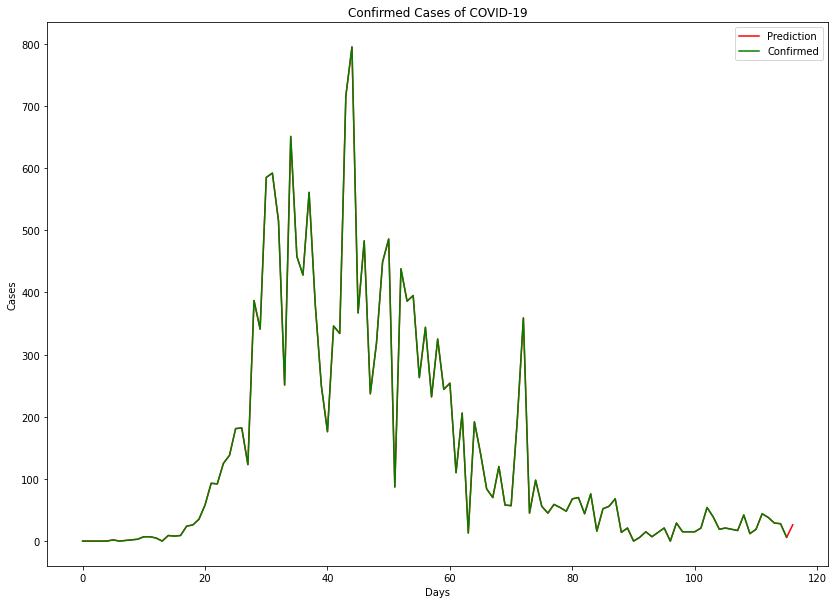

In [ ]:
df_norte_fo, df_norte_forecast = createStructure_plot(df_norte_aux, norte_forecast, scaler_norte)
print("Previsão\n\tNovos casos para a região do Norte (21 de junho):", int(norte_forecast[0]))
plot_forecast(df_norte_fo, df_norte_forecast)

Previsão
	Novos casos para a região do Centro (21 de junho): 11


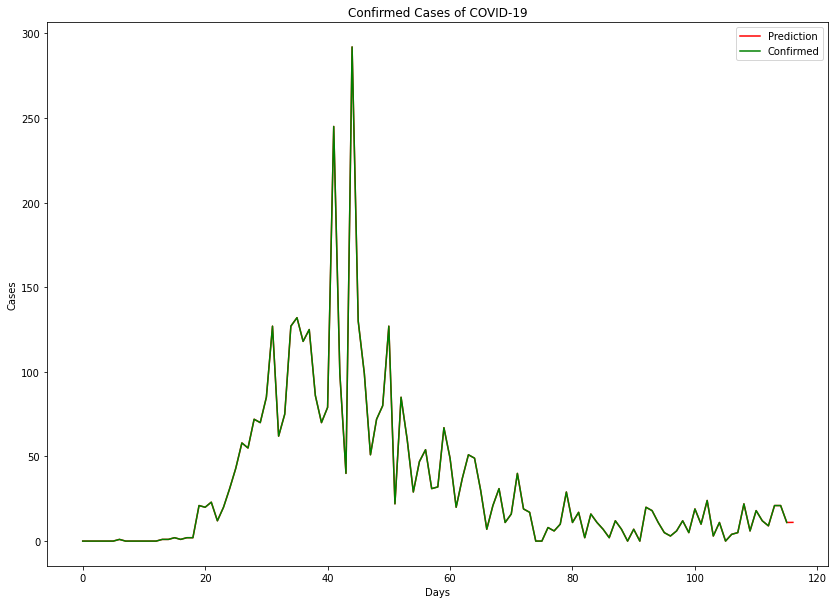

In [ ]:
df_centro_fo, df_centro_forecast = createStructure_plot(df_centro_aux, centro_forecast, scaler_centro)
print("Previsão\n\tNovos casos para a região do Centro (21 de junho):", int(centro_forecast[0]))
plot_forecast(df_centro_fo, df_centro_forecast)

Previsão
	Novos casos para a região de Lisboa e Vale do Tejo (21 de junho): 170


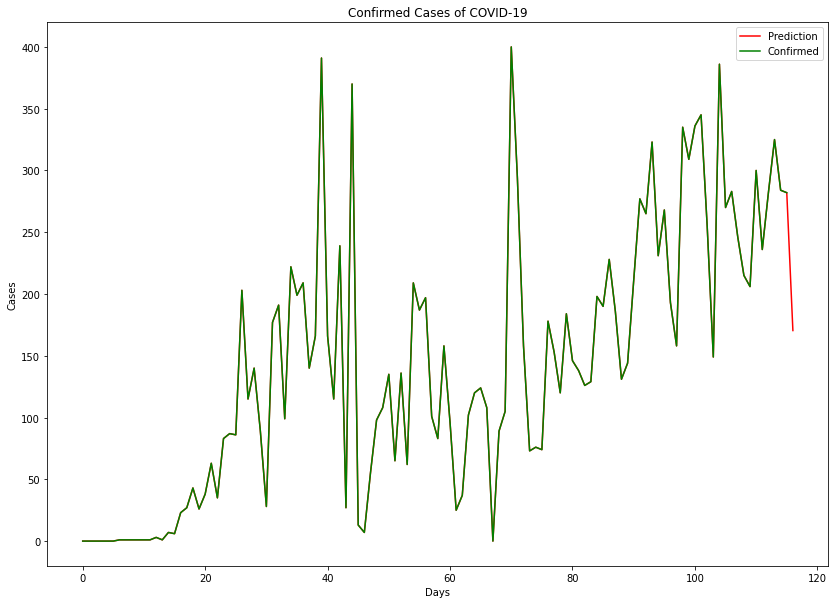

In [ ]:
df_lvt_fo, df_lvt_forecast = createStructure_plot(df_lvt_aux, lvt_forecast, scaler_lvt)
print("Previsão\n\tNovos casos para a região de Lisboa e Vale do Tejo (21 de junho):", int(lvt_forecast[0]))
plot_forecast(df_lvt_fo, df_lvt_forecast)

Previsão
	Novos casos para a região do Algarve (21 de junho): 0


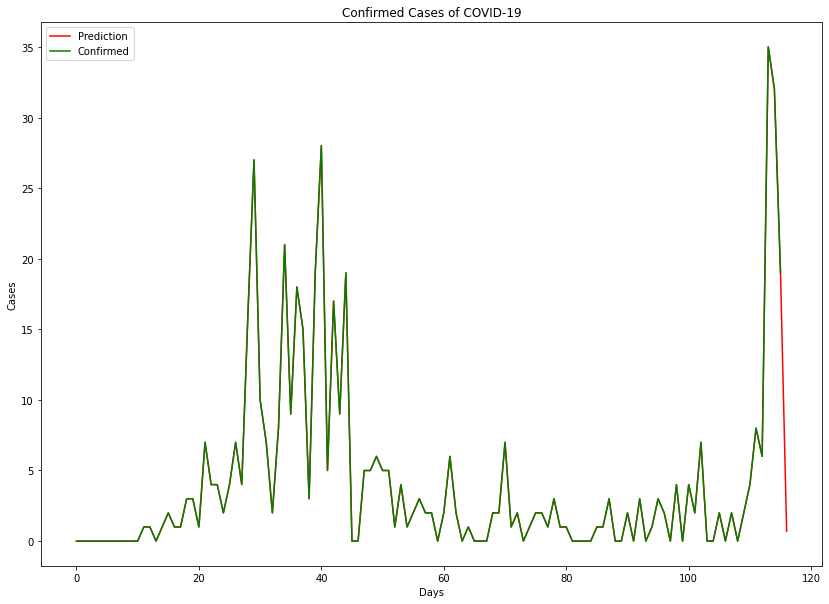

In [ ]:
df_algarve_fo, df_algarve_forecast = createStructure_plot(df_algarve_aux, algarve_forecast, scaler_algarve)
print("Previsão\n\tNovos casos para a região do Algarve (21 de junho):", int(algarve_forecast[0]))
plot_forecast(df_algarve_fo, df_algarve_forecast)

Previsão
	Novos casos para a região do Alentejo (21 de junho): 2


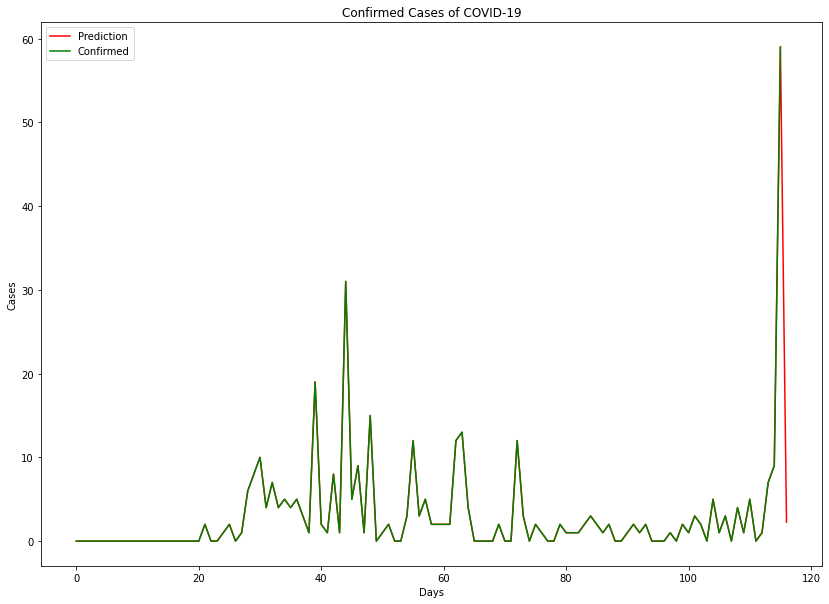

In [ ]:
df_alentejo_fo, df_alentejo_forecast = createStructure_plot(df_alentejo_aux, alentejo_forecast, scaler_alentejo)
print("Previsão\n\tNovos casos para a região do Alentejo (21 de junho):", int(alentejo_forecast[0]))
plot_forecast(df_alentejo_fo, df_alentejo_forecast)

#Conclusões

In [ ]:
rnn_results = read_dataset(bestFileRNN_Multi)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
print(rnn_results)

          test_loss  test_acc   val_acc  val_loss           layers  dropout algorithm  learning rate  epochs  batch_size model
city                                                                                                                          
Norte      0.026462  0.022173  0.017235  0.020118    [50, 100, 50]      0.7      adam         0.0100     500           8  LSTM
Centro     0.025399  0.021813  0.017296  0.022030        [100, 50]      0.2   rmsprop         0.0100    1000          16   RNN
LVT        0.256917  0.226956  0.234035  0.255843  [100, 100, 100]      0.7   rmsprop         0.0100   10000          64   RNN
Algarve    0.446683  0.278896  0.049223  0.060957       [100, 150]      0.5      adam         0.0010   10000          16  LSTM
Alentejo   0.298899  0.128922  0.019717  0.024569    [50, 100, 50]      0.5   rmsprop         0.0001     500          16   GRU
